In [1]:
import pyspark
from pyspark.sql import SparkSession

In [3]:
import boto3
import io

## Initialize

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [3]:
print(pyspark.__version__)

3.3.1


In [4]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("ChicagoCrimeAnalysis") \
    .getOrCreate()

## Read data from S3

In [5]:
# df = spark.read.option("header", True).csv("s3a://g5crime/data/data_raw.csv")
# we will ignore using s3 and load data from local file system(it is in gitignore)
df = spark.read.option("header", True).csv("raw_data.csv")

## Store Dataframe (Pandas) to S3 

In [ ]:
def save_df_to_s3_parquet(df, bucket_name, key):

    buffer = io.BytesIO()
    df.to_parquet(buffer, index=False)
    buffer.seek(0)
    
    s3 = boto3.client("s3")
    s3.put_object(Bucket=bucket_name, Key=key, Body=buffer.getvalue())
    
    print(f"Saved DF to s3://{bucket_name}/{key}")

## Let's convert the date to proper format first

In [6]:
from pyspark.sql.functions import to_timestamp, col

df = df.withColumn("Date", to_timestamp("Date", "MM/dd/yyyy hh:mm:ss a"))
df.show(5)


+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|13948166|   JJ391522|2025-08-27 00:00:00|    002XX E HURON ST|0281|CRIMINAL SEXUAL A...|      NON-AGGRAVATED|HOSPITAL BUILDING

# Haseeb Part Starts here (Count crime over a timeframe)

We will aggregate hourly, daily, monthly and yearly

In [7]:
from pyspark.sql.functions import (
    count, year, month, dayofmonth, hour, date_format, to_timestamp
)

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter

def plot_crime_count(df, timeframe):
    sns.set(style="whitegrid")
    plt.figure(figsize=(14,6))

    # Plot crime counts
    plt.plot(df[timeframe], df["Crime_Count"], label="Crime Count", marker='o', color='tab:blue', alpha=0.7)

    # Plot trendlines
    plt.plot(df[timeframe], df["Trendline_LR"], label="Linear Regression", linestyle='--', color='tab:red')
    plt.plot(df[timeframe], df["Trendline_7MA"], label="7-period MA", linestyle='-.', color='tab:green')
    plt.plot(df[timeframe], df["Trendline_15MA"], label="15-period MA", linestyle=':', color='tab:orange')
    plt.plot(df[timeframe], df["Trendline_30MA"], label="30-period MA", linestyle='-', color='tab:purple')

    # Labels and title
    plt.xlabel(timeframe)
    plt.ylabel("Crime Count")
    plt.title(f"Crime Count over {timeframe}", fontsize=16)
    plt.legend()

    # Improve date formatting if timeframe is not ordinal
    if pd.api.types.is_datetime64_any_dtype(df[timeframe]):
        plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [11]:
def group_by_timeframe(df, timeframe):
    formats = {
        "Yearly": "yyyy",
        "Monthly": "yyyy-MM",
        "Daily": "yyyy-MM-dd",
        "Hourly": "yyyy-MM-dd HH"
    }

    fmt = formats.get(timeframe, "yyyy-MM-dd")
    output_df = df.groupBy(date_format("Date", fmt).alias(timeframe)) \
             .agg(count("*").alias("Crime_Count")) \
             .orderBy(timeframe)
    
    # Convert to Pandas DataFrame for further processing
    output_df = output_df.toPandas()
    
    # we need this to fit the trendlines
    output_df["Ordinal Time"] = pd.to_datetime(output_df[timeframe]).astype("int64") / 1e9

    # normalize time period for LR
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(output_df[["Ordinal Time"]])

    # we will fit the trendline: linear regression, MA (of last 7, 15, 30 periods)
    model = LinearRegression().fit(X_scaled, output_df["Crime_Count"])
    output_df["Trendline_LR"] = model.predict(X_scaled)

    output_df["Trendline_7MA"] = output_df["Crime_Count"].rolling(window=7, min_periods=1).mean()
    output_df["Trendline_15MA"] = output_df["Crime_Count"].rolling(window=15, min_periods=1).mean()
    output_df["Trendline_30MA"] = output_df["Crime_Count"].rolling(window=30, min_periods=1).mean()

    return output_df

In [19]:
# from pyspark.sql import functions as F
# from pyspark.ml.feature import VectorAssembler, StandardScaler
# from pyspark.ml.regression import LinearRegression
# from pyspark.sql.window import Window

# def group_by_timeframe(df, timeframe):
#     formats = {
#         "Yearly": "yyyy",
#         "Monthly": "yyyy-MM",
#         "Daily": "yyyy-MM-dd",
#         "Hourly": "yyyy-MM-dd HH"
#     }

#     fmt = formats.get(timeframe, "yyyy-MM-dd")
#     output_df = df.groupBy(date_format("Date", fmt).alias(timeframe)) \
#              .agg(count("*").alias("Crime_Count")) \
#              .orderBy(timeframe)
    
#     # Convert date to numeric for LR
#     output_df = output_df.withColumn("OrdinalTime", F.unix_timestamp(F.col(timeframe), format = fmt))

#     # assemble the features
#     assembler = VectorAssembler(inputCols=["OrdinalTime"], outputCol="features", handleInvalid="skip")
#     output_df = assembler.transform(output_df)

#     if output_df.count() == 0:
#         print("No data available after filtering.")
#         return None

#     # we now scale the values of assembler since it is too large
#     scalar = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
#     scaler_model = scalar.fit(output_df)
#     output_df = scaler_model.transform(output_df)

#     # fit the LR model
#     lr = LinearRegression(featuresCol="scaledFeatures", labelCol="Crime_Count")
#     lr_model = lr.fit(output_df)
#     output_df = lr_model.transform(output_df)

#     output_df = output_df.withColumnRenamed("prediction", "Trendline_LR")

#     # compute moving averages
#     window_7 = Window.orderBy(timeframe).rowsBetween(-6, 0)
#     window_15 = Window.orderBy(timeframe).rowsBetween(-14, 0)
#     window_30 = Window.orderBy(timeframe).rowsBetween(-29, 0)

#     output_df = output_df.withColumn("Trendline_7MA", F.avg("Crime_Count").over(window_7))
#     output_df = output_df.withColumn("Trendline_15MA", F.avg("Crime_Count").over(window_15))
#     output_df = output_df.withColumn("Trendline_30MA", F.avg("Crime_Count").over(window_30))

#     return output_df.select(timeframe, "Crime_Count", "Trendline_LR", "Trendline_7MA", "Trendline_15MA", "Trendline_30MA")


#### Yearly Crime Aggregation

In [12]:
crime_yearly = group_by_timeframe(df, "Yearly")
crime_yearly.head()

,Yearly,Crime_Count,Ordinal Time,Trendline_LR,Trendline_7MA,Trendline_15MA,Trendline_30MA
0,2001,485946,9.783072e+08,494087.898427,485946.0,485946.0,485946.0
1,2002,486830,1.009843e+09,480899.562692,486388.0,486388.0,486388.0
2,2003,475996,1.041379e+09,467711.226957,482924.0,482924.0,482924.0
3,2004,469438,1.072915e+09,454522.891222,479552.5,479552.5,479552.5
4,2005,453785,1.104538e+09,441298.423060,474399.0,474399.0,474399.0


Monthly

In [16]:
crime_monthly = group_by_timeframe(df, "Monthly")
crime_monthly.head()

,Monthly,Crime_Count,Ordinal Time,Trendline_LR,Trendline_7MA,Trendline_15MA,Trendline_30MA
0,2001-01,38126,978307200.0,41237.827975,38126.0,38126.0,38126.0
1,2001-02,33788,980985600.0,41148.856832,35957.0,35957.0,35957.0
2,2001-03,40574,983404800.0,41068.495799,37496.0,37496.0,37496.0
3,2001-04,40098,986083200.0,40979.524656,38146.5,38146.5,38146.5
4,2001-05,41846,988675200.0,40893.423550,38886.4,38886.4,38886.4


In [13]:
crime_daily = group_by_timeframe(df, "Daily")
crime_daily.head()

,Daily,Crime_Count,Ordinal Time,Trendline_LR,Trendline_7MA,Trendline_15MA,Trendline_30MA
0,2001-01-01,1832,978307200.0,1356.543502,1832.000000,1832.000000,1832.000000
1,2001-01-02,1143,978393600.0,1356.449217,1487.500000,1487.500000,1487.500000
2,2001-01-03,1151,978480000.0,1356.354932,1375.333333,1375.333333,1375.333333
3,2001-01-04,1166,978566400.0,1356.260647,1323.000000,1323.000000,1323.000000
4,2001-01-05,1267,978652800.0,1356.166361,1311.800000,1311.800000,1311.800000


In [14]:
crime_hourly = group_by_timeframe(df, "Hourly")
crime_hourly.head()

,Hourly,Crime_Count,Ordinal Time,Trendline_LR,Trendline_7MA,Trendline_15MA,Trendline_30MA
0,2001-01-01 00,424,978307200.0,56.517541,424.000000,424.000000,424.000000
1,2001-01-01 01,91,978310800.0,56.517378,257.500000,257.500000,257.500000
2,2001-01-01 02,78,978314400.0,56.517214,197.666667,197.666667,197.666667
3,2001-01-01 03,71,978318000.0,56.517051,166.000000,166.000000,166.000000
4,2001-01-01 04,53,978321600.0,56.516887,143.400000,143.400000,143.400000


Let's plot for testing

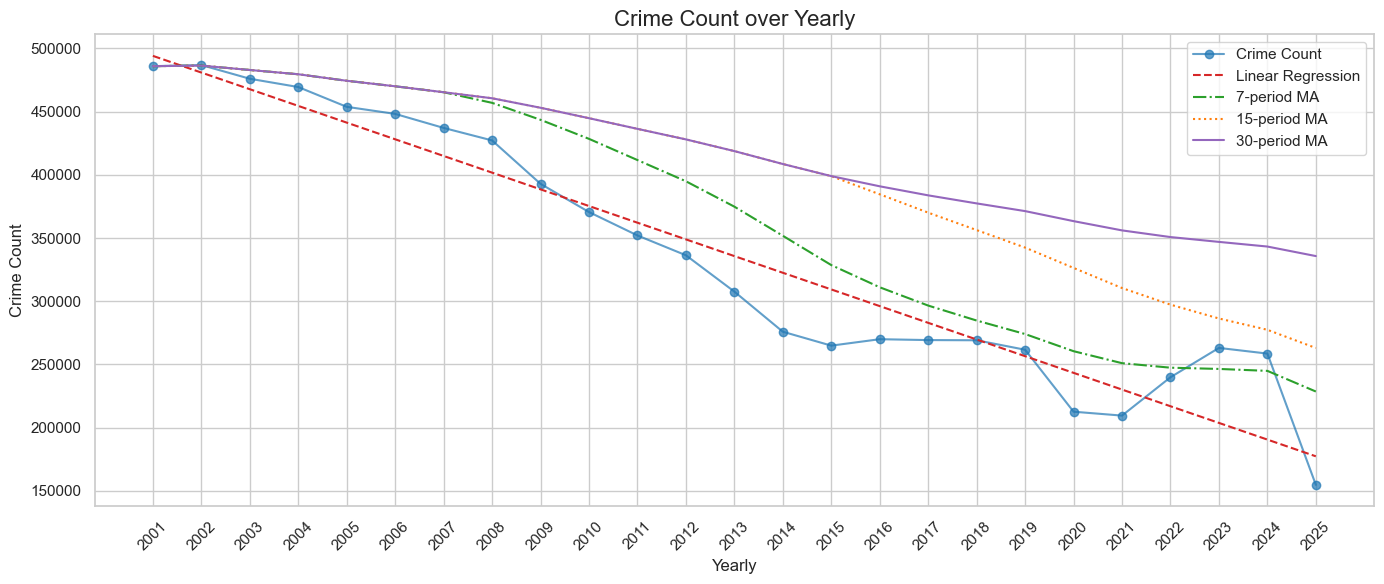

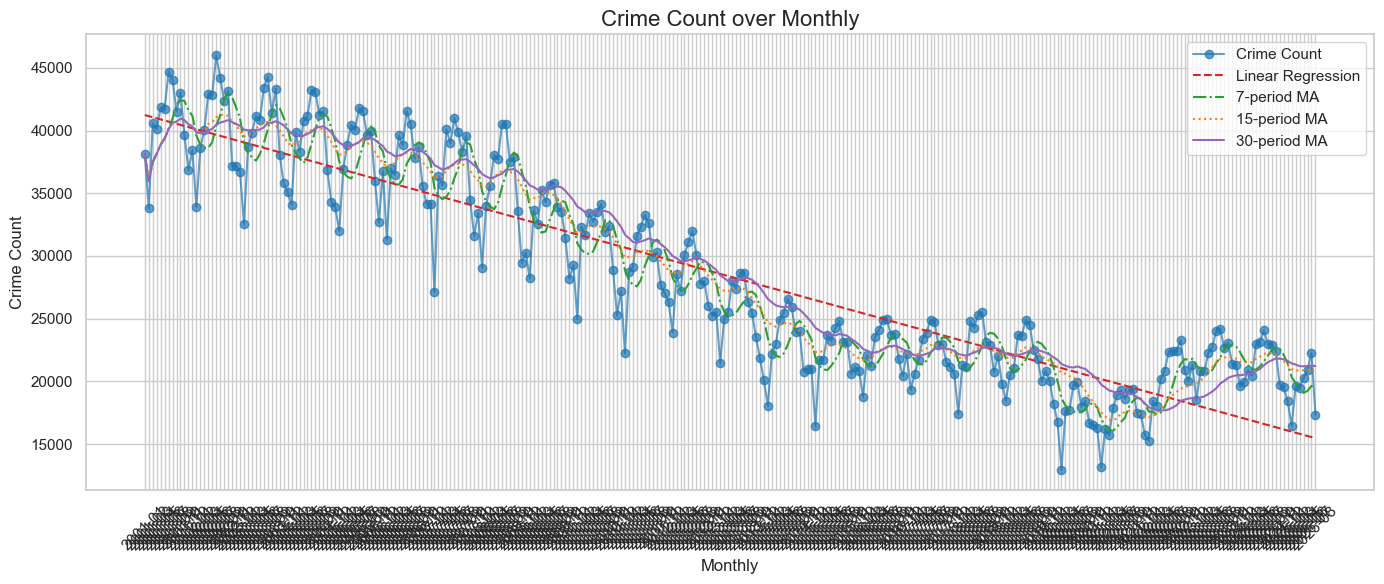

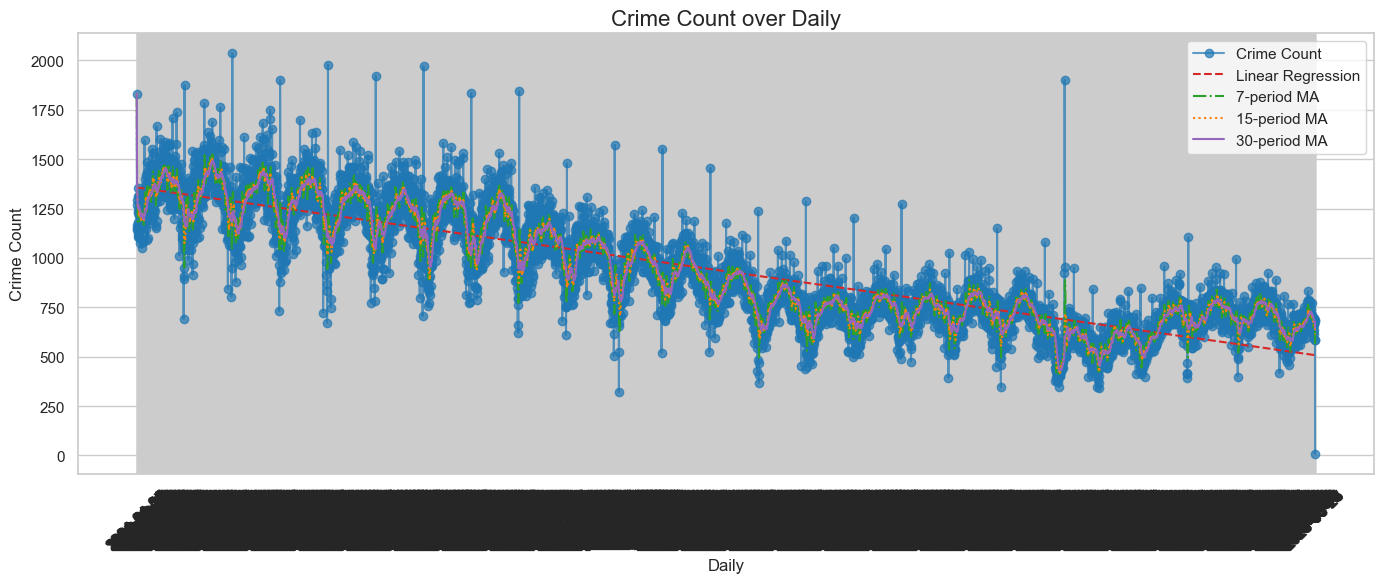

KeyboardInterrupt: 

In [ ]:
plot_crime_count(crime_yearly, "Yearly")
plot_crime_count(crime_monthly, "Monthly")
plot_crime_count(crime_daily, "Daily")
# plot_crime_count(crime_hourly, "Hourly") # takes a lot of time 

Finally store the output to S3 bucket

In [ ]:
# save_df_to_s3_parquet(crime_daily, "XYZ", "output/crime_daily.parquet")
# save_df_to_s3_parquet(crime_hourly, "XYZ", "output/crime_hourly.parquet")
# save_df_to_s3_parquet(crime_monthly, "XYZ", "output/crime_monthly.parquet")
# save_df_to_s3_parquet(crime_yearly, "XYZ", "output/crime_yearly.parquet")
